In [2]:
%load_ext autoreload
%autoreload 2

import utils
from darts import TimeSeries
import numpy as np
import pandas as pd
from darts.models import NaiveSeasonal
from darts.metrics import rmse, mape, r2_score, mae
import matplotlib.pyplot as plt

In [3]:
# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1)


# Ensure that all covariates are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_nodiff_scaled).slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_scaled).slice_intersect(covars_diff_yoy_scaled)
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

/Users/Xavier/cdpq-ia/utils.py:225: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  autres = autres.apply(pd.to_numeric, errors="ignore")


# Naive Model

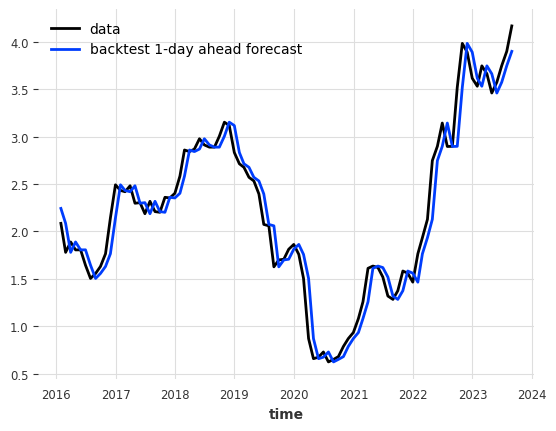

,mape,mae,rmse
0,7.703667,0.145772,0.199121
1,13.698501,0.250774,0.330233
2,18.232449,0.321901,0.426595
3,22.748020,0.394540,0.505532
4,26.932014,0.463551,0.577666
5,31.113430,0.534647,0.655761
6,34.924240,0.599800,0.728407
7,38.514225,0.658137,0.795953
8,42.382820,0.722138,0.864049
9,45.931522,0.781228,0.930050


In [11]:
model = NaiveSeasonal()
model.fit(train_ts_scaled)

results = []
for h in range(1, 37):
    historical_fcast_theta = model.historical_forecasts(
        last_points_only=True,
        series=ts,
        start=pd.Timestamp("2016-01-01"),
        forecast_horizon=h,
        verbose=False,
        past_covariates=None,
        enable_optimization=False,
    )

    if h == 1:
        ts.drop_before(pd.Timestamp("2016-01-01")).plot(label="data")
        historical_fcast_theta.plot(label="backtest 1-day ahead forecast")
        plt.show()

    mapee = mape(ts, historical_fcast_theta)
    rmsee = rmse(ts, historical_fcast_theta)
    r2 = r2_score(ts, historical_fcast_theta)
    maee = mae(ts, historical_fcast_theta)

    results.append([h, mapee, rmsee, r2, maee])

results = pd.DataFrame(results, columns=["h", "mape", "rmse", "r2", "mae"])
results[["mape", "mae", "rmse"]]